In [40]:
#What's Cooking 

In [18]:
from collections import Counter
import zipfile

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

import os
for dirname, _, filenames in os.walk('I3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [19]:
train_archive = zipfile.ZipFile('train.json.zip', 'r')
train_data = pd.read_json(train_archive.open('train.json'))
print('train shape:', train_data.shape)

test_archive = zipfile.ZipFile('test.json.zip', 'r')
test_data = pd.read_json(test_archive.open('test.json'))
print('test shape:', test_data.shape)

sample_submission_archive = zipfile.ZipFile('sample_submission.csv.zip', 'r')
sample_submission_data = pd.read_csv(sample_submission_archive.open('sample_submission.csv'))

train shape: (39774, 3)
test shape: (9944, 2)


In [9]:
# shapes of datasets
print("Train :",train.shape)
print("Test:",test.shape)

Train : (39774, 3)
Test: (9944, 2)


In [20]:
train_data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [21]:
train_data.info()  # clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [22]:
train_data['size'] = train_data['ingredients'].apply(len)

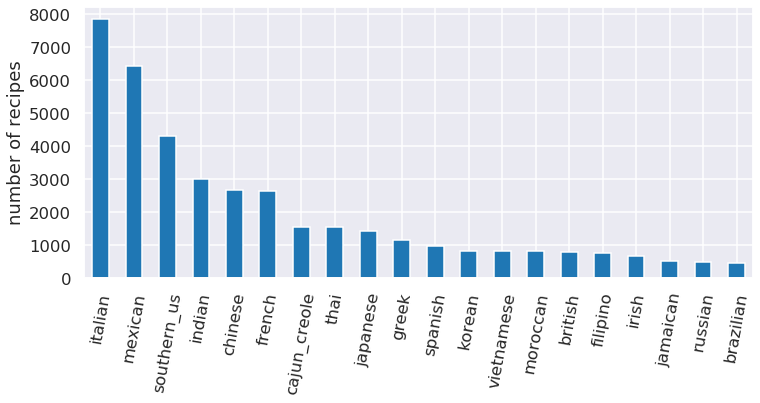

In [23]:
with sns.axes_style('darkgrid'), sns.plotting_context('talk'):
    pd.value_counts(train_data['cuisine']).plot.bar(figsize=(12, 5))
    plt.xticks(rotation=80)
    plt.ylabel('number of recipes')

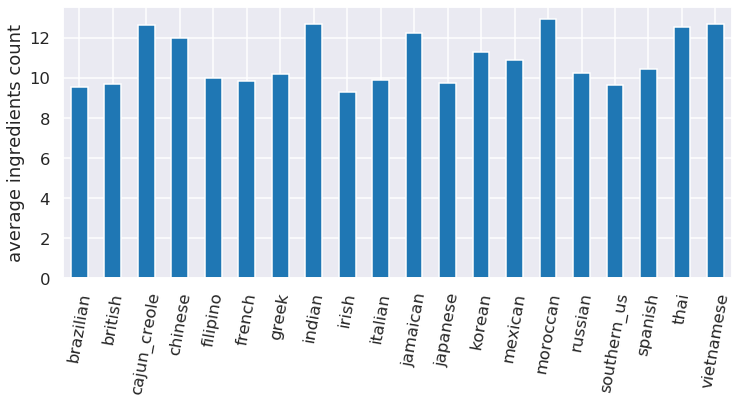

In [24]:
with sns.axes_style('darkgrid'), sns.plotting_context('talk'):
    train_data.groupby('cuisine')['size'].mean().plot.bar(figsize=(12, 5))
    plt.xticks(rotation=80)
    plt.ylabel('average ingredients count')
    plt.xlabel('')

In [25]:
def to_counters(recipes):
    counters = []
    for recipe in recipes:
        counters.append(Counter(recipe))
    return counters


class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=None, accumulate_outliers=False):
        self.vocabulary_size = vocabulary_size 
        self.bias = int(accumulate_outliers)        
        
        
    def fit(self, X, y=None):
        total_count = Counter()
        for word_counts in X:
            for word, count in word_counts.items():
                total_count[word] += 1
        if self.vocabulary_size is None:
            self.vocabulary_size = len(total_count)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + self.bias for index, (word, count) in enumerate(most_common)}
        return self
    
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                if self.bias or word in self.vocabulary_:
                    rows.append(row)
                    cols.append(self.vocabulary_.get(word, 0))
                    data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), (self.vocabulary_size + self.bias)))

In [26]:
X = train_data['ingredients'].values
y = train_data['cuisine'].values

In [27]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, valid_index = next(sss.split(X, y))
X_train, X_valid = X[train_index], X[valid_index]
y_train, y_valid = y[train_index], y[valid_index]
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((31819,), (7955,), (31819,), (7955,))

In [28]:
vectorizer = WordCounterToVectorTransformer()
X_train_sparce = vectorizer.fit_transform(to_counters(X_train))
X_valid_sparce = vectorizer.transform(to_counters(X_valid))
X_train_sparce[X_train_sparce > 1] = 1
X_valid_sparce[X_valid_sparce > 1] = 1
X_train_vec = X_train_sparce.toarray()
X_valid_vec = X_valid_sparce.toarray()

onehot = OneHotEncoder()
y_train_onehot = onehot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_valid_onehot = onehot.transform(y_valid.reshape(-1, 1)).toarray()

In [29]:
def fit_classifier(classifier):
    classifier.fit(X_train_sparce, y_train)
    y_train_pred = classifier.predict(X_train_sparce)
    y_valid_pred = classifier.predict(X_valid_sparce)
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    print(f'train accuracy: {train_acc:.5f}\nvalidation accuracy: {valid_acc:.5f}')

In [30]:
mnb = MultinomialNB()
fit_classifier(mnb)

train accuracy: 0.77422
validation accuracy: 0.72608


In [31]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
fit_classifier(knn)

train accuracy: 0.61778
validation accuracy: 0.52634


In [32]:
rfc = RandomForestClassifier(n_estimators=100, 
                             max_depth=60,
                             min_samples_leaf=5, 
                             random_state=0, 
                             class_weight='balanced_subsample',                            
                             max_features=0.2, 
                             n_jobs=-1)
fit_classifier(rfc)

train accuracy: 0.67199
validation accuracy: 0.57838


In [33]:
gbc = GradientBoostingClassifier(n_estimators=30, max_features=0.2, random_state=0)
fit_classifier(gbc)

train accuracy: 0.67510
validation accuracy: 0.63834


In [34]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
fit_classifier(abc)

train accuracy: 0.55105
validation accuracy: 0.53664


In [35]:
vc_all_h = VotingClassifier(estimators=[('mnb', mnb), ('knn', knn), ('rfc', rfc), ('gbc', gbc), ('abc', abc)], n_jobs=-1)
fit_classifier(vc_all_h)

train accuracy: 0.73349
validation accuracy: 0.67354


In [36]:
vc_best_h = VotingClassifier(estimators=[('mnb', mnb), ('rfc', rfc), ('gbc', gbc)], n_jobs=-1)
fit_classifier(vc_best_h)

train accuracy: 0.75423
validation accuracy: 0.69428


In [37]:
vc_all_s = VotingClassifier(estimators=[('mnb', mnb), ('knn', knn), ('rfc', rfc), ('gbc', gbc), ('abc', abc)], voting='soft', n_jobs=-1)
fit_classifier(vc_all_s)

train accuracy: 0.80289
validation accuracy: 0.73979


In [38]:
vc_best_s = VotingClassifier(estimators=[('mnb', mnb), ('rfc', rfc), ('gbc', gbc)], voting='soft', n_jobs=-1)
fit_classifier(vc_best_s)

train accuracy: 0.79248
validation accuracy: 0.74318
